In [ ]:
import torch

import sys
from pathlib import Path
import os
assert "HF_TOKEN" in os.environ
project_root = Path().resolve().parent
sys.path.append(str(project_root))


from src.evaluation.evaluate import evaluate_and_plot, evaluate_benchmark
from src.methods.fewshot.sampling import sample_k_per_class
from src.methods.fewshot.prototypical import compute_prototypes, classify
from transformers import HubertModel
from src.datasets.urban_sound_8k import UrbanDataset
from src.methods.fewshot.benchmark import benchmark_fewshot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
root_dir = ""

dataset = UrbanDataset(root_dir)

print("Classes :", dataset.classes)
print("Nombre total de fichiers :", len(dataset))


Resuming download from 55574528 bytes (5970657996 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/chrisfilo/urbansound8k?dataset_version_number=1 (55574528/6026232524) bytes left.


100%|██████████| 5.61G/5.61G [14:28<00:00, 6.87MB/s]

Extracting files...


Classes : ['fold1', 'fold10', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9']
Nombre total de fichiers : 8732


In [11]:
X = []
y = []

for waveform, label in dataset:
    X.append(waveform)
    y.append(label)

X = torch.stack(X)      
y = torch.tensor(y)     


print(X.shape)  
print(y.shape)  


torch.Size([8732, 16000])
torch.Size([8732])


In [12]:
X_support, y_support, X_query, y_query = sample_k_per_class(
    X, y, k=1
)

In [13]:
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", use_safetensors=True)
hubert.eval().to(device)

for p in hubert.parameters():
    p.requires_grad = False

In [14]:
prototypes, proto_labels = compute_prototypes(
    hubert, X_support, y_support
)

preds = classify(
    hubert, X_query, prototypes, proto_labels
)

acc = (preds.cpu() == y_query).float().mean()
print("Few-shot accuracy:", acc.item())


: 

## Benchmark

In [8]:
results = {}
for k in [1,5,10]:
    results[k] = benchmark_fewshot(model=hubert, X=X, y=y, device=device, k_shot=k, n_tasks=10)


10-shot benchmark: 100%|██████████| 10/10 [01:41<00:00, 10.17s/it]



===== Few-shot evaluation summary =====

--- 1-shot ---
Accuracy : 0.5500 ± 0.0935
F1 macro : 0.5491


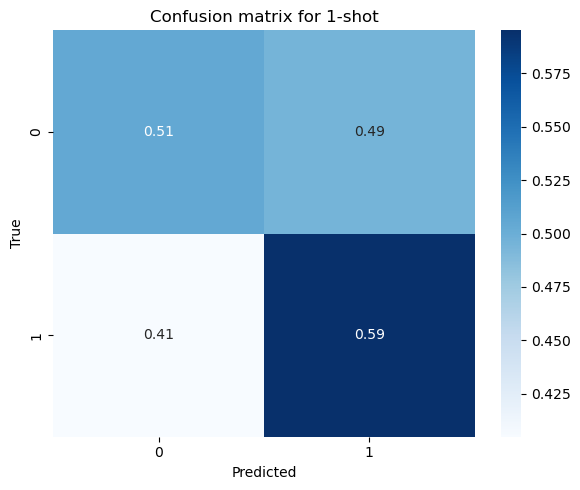


=== Evaluation metrics ===
accuracy    : 0.5500
f1_macro    : 0.5491
precision_macro: 0.5504
recall_macro: 0.5500


/Users/ilan/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
python(57363) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


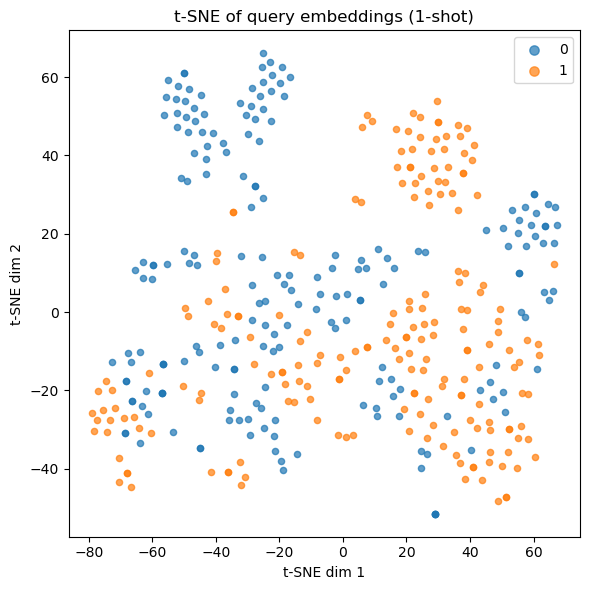


--- 5-shot ---
Accuracy : 0.6675 ± 0.0956
F1 macro : 0.6667


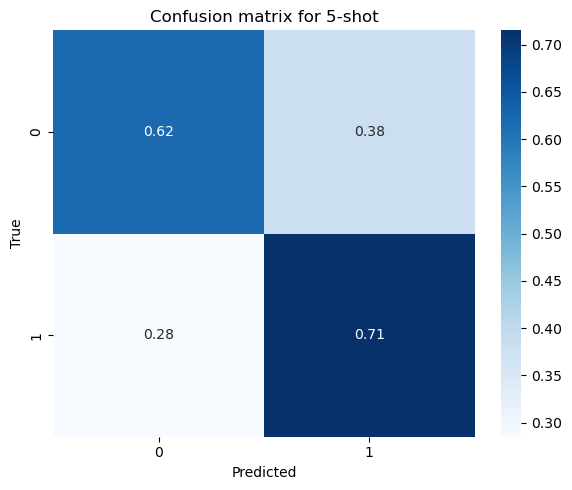


=== Evaluation metrics ===
accuracy    : 0.6675
f1_macro    : 0.6667
precision_macro: 0.6690
recall_macro: 0.6675


/Users/ilan/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


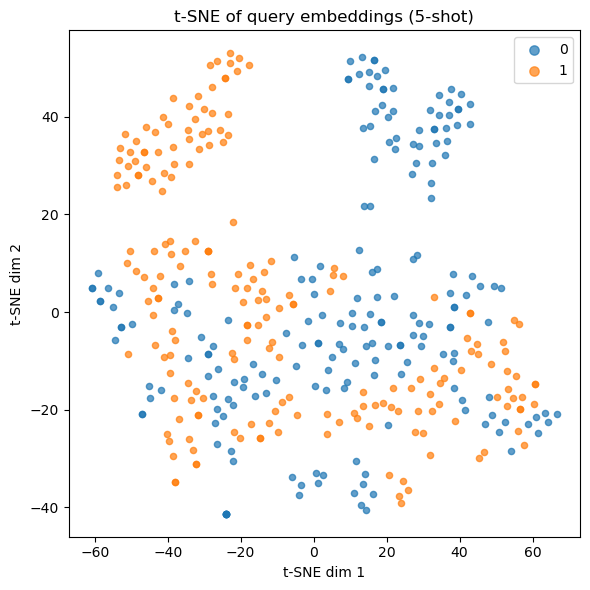


--- 10-shot ---
Accuracy : 0.6275 ± 0.1092
F1 macro : 0.6268


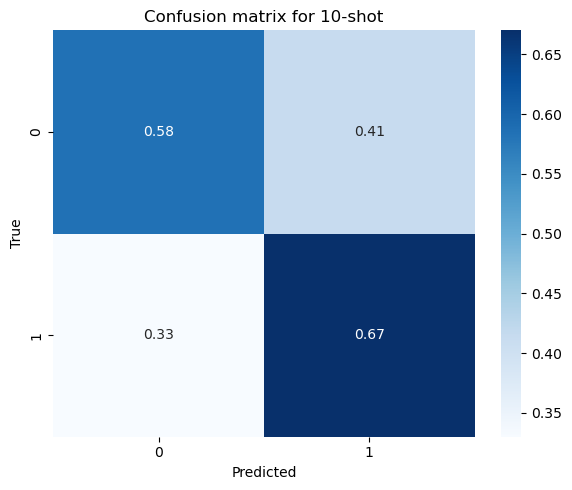


=== Evaluation metrics ===
accuracy    : 0.6275
f1_macro    : 0.6268
precision_macro: 0.6284
recall_macro: 0.6275


/Users/ilan/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


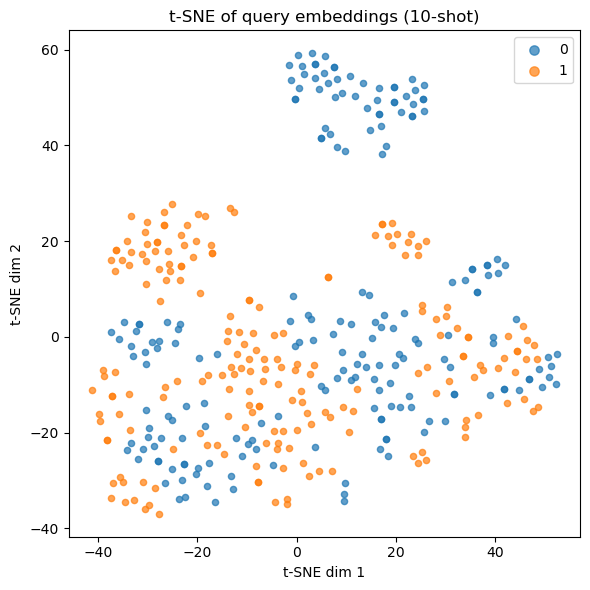

In [9]:
evaluate_benchmark(results, class_names=dataset.classes)